# Exploratory Data Analysis (EDA)
This notebook provides an initial exploration of the malaria blood smear image dataset.  
We aim to understand the data structure, visualize sample images, check class balance, and identify potential issues before building models.

In [4]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 2.3.1
Pandas version: 2.3.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


## 1. Dataset Overview

We have two main datasets for this project:

1. **Cropped Dataset (NIH Malaria Dataset)**: 27,558 pre-cropped cell images
   - `data/raw/cropped/Parasitized/`: Malaria-infected cell images
   - `data/raw/cropped/Uninfected/`: Healthy cell images

2. **Uncropped Dataset (Full Slide Images)**: 965 full microscopy slide images
   - `data/raw/uncropped/NIH-NLM-ThinBloodSmearsPf/Polygon Set/`: Full slides with polygon annotations
   - `data/raw/uncropped/NIH-NLM-ThinBloodSmearsPf/Point Set/`: Full slides with point annotations

Let's start by exploring the directory structure and basic statistics.

In [5]:
# Define data paths
base_path = Path("../data/raw")
cropped_path = base_path / "cropped"
uncropped_path = base_path / "uncropped"

# Check if directories exist
print("Checking dataset directories...")
print(f"Base path exists: {base_path.exists()}")
print(f"Cropped data path exists: {cropped_path.exists()}")
print(f"Uncropped data path exists: {uncropped_path.exists()}")

# Explore cropped dataset structure
if cropped_path.exists():
    print("\n=== CROPPED DATASET STRUCTURE ===")
    for item in cropped_path.iterdir():
        if item.is_dir():
            count = len(list(item.glob("*.png")))
            print(f"{item.name}: {count} images")
else:
    print("Cropped dataset directory not found!")

# Explore uncropped dataset structure
if uncropped_path.exists():
    print("\n=== UNCROPPED DATASET STRUCTURE ===")
    for item in uncropped_path.iterdir():
        print(f"- {item.name}")
        if item.is_dir():
            for subitem in item.iterdir():
                if subitem.is_dir():
                    print(f"  - {subitem.name}")
else:
    print("Uncropped dataset directory not found!")

Checking dataset directories...
Base path exists: True
Cropped data path exists: True
Uncropped data path exists: True

=== CROPPED DATASET STRUCTURE ===
Parasitized: 13779 images
Parasitized: 13779 images
Uninfected: 13779 images

=== UNCROPPED DATASET STRUCTURE ===
- Data License Agreement.docx
- Dataset_statistics.xlsx
- Point Set
  - 143C39P4thinF_original
  - 144C3thin_original
  - 145C42P5thin_original
  - 147C4thin_original
  - 148C47P8thinOriginalOlympusCX21
  - 149C48P9thinF
  - 151C50P11thinF
  - 152C51AP12thinF
  - 154C53P14thinF
  - 155C54P15thinF
  - 157C56P17thinF
  - 159C58P19thinF
  - 200C59P20thinF
  - 201C60P21thinF
  - 202C61P22N_ThinF
  - 203C62P23N_ThinF
  - 204C63P24N_ThinF
  - 205C64P25N_ThinF
  - 206C65P26N_ThinF
  - 207C66P27N_ThinF
  - 210C69P30N_ThinF
  - 213C72P33_ThinF
  - 214C73P34_ThinF
  - 215C74P35_ThinF
  - 216C75P36_ThinF
  - 218C76P37ThinF
  - 219C77P38ThinF
  - 220C78P39ThinF
  - 222C80P41ThinF
  - 223C81P42ThinF
  - 224C82P43ThinF
  - 225C83P44Thin

## 2. Cropped Dataset Analysis

The cropped dataset contains individual cell images that are already classified. This will be used for:
1. Training the CNN ensemble models
2. Initial performance evaluation
3. Understanding cell image characteristics

=== CROPPED DATASET DETAILED ANALYSIS ===

Parasitized class:
  Number of images: 13779
  Sample image dimensions: [(142, 148), (148, 208), (139, 151), (145, 154), (133, 154)]

Parasitized class:
  Number of images: 13779
  Sample image dimensions: [(142, 148), (148, 208), (139, 151), (145, 154), (133, 154)]

Uninfected class:
  Number of images: 13779
  Sample image dimensions: [(160, 139), (145, 136), (145, 142), (100, 112), (124, 139)]

Total images: 27558
Parasitized: 13779 (50.0%)
Uninfected: 13779 (50.0%)

Uninfected class:
  Number of images: 13779
  Sample image dimensions: [(160, 139), (145, 136), (145, 142), (100, 112), (124, 139)]

Total images: 27558
Parasitized: 13779 (50.0%)
Uninfected: 13779 (50.0%)


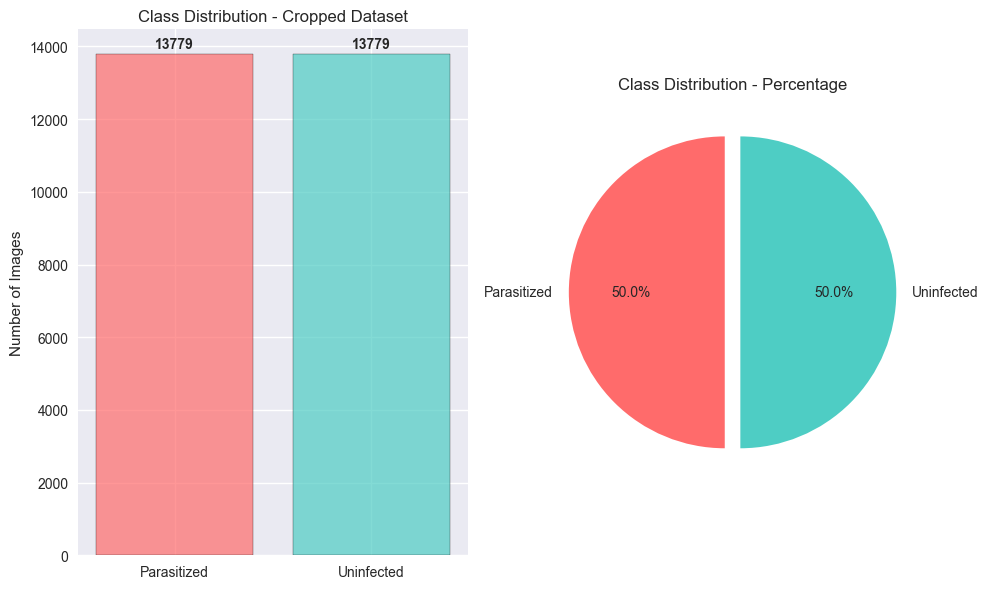


Class imbalance ratio: 1.00:1
✅ Classes are relatively balanced


In [6]:
# Analyze cropped dataset
def analyze_cropped_dataset(data_path):
    """Analyze the cropped malaria dataset"""
    
    dataset_stats = {}
    
    # Check each class directory
    for class_dir in ['Parasitized', 'Uninfected']:
        class_path = data_path / class_dir
        
        if class_path.exists():
            # Count images
            image_files = list(class_path.glob("*.png"))
            count = len(image_files)
            dataset_stats[class_dir] = count
            
            print(f"\n{class_dir} class:")
            print(f"  Number of images: {count}")
            
            # Sample a few images to check dimensions
            if count > 0:
                sample_sizes = []
                for i, img_path in enumerate(image_files[:5]):  # Check first 5 images
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        h, w = img.shape[:2]
                        sample_sizes.append((w, h))
                
                if sample_sizes:
                    print(f"  Sample image dimensions: {sample_sizes}")
        else:
            print(f"{class_dir} directory not found!")
            dataset_stats[class_dir] = 0
    
    return dataset_stats

# Analyze the dataset
if cropped_path.exists():
    print("=== CROPPED DATASET DETAILED ANALYSIS ===")
    stats = analyze_cropped_dataset(cropped_path)
    
    # Calculate class balance
    total_images = sum(stats.values())
    print(f"\nTotal images: {total_images}")
    
    if total_images > 0:
        for class_name, count in stats.items():
            percentage = (count / total_images) * 100
            print(f"{class_name}: {count} ({percentage:.1f}%)")
        
        # Visualize class distribution
        plt.figure(figsize=(10, 6))
        
        # Bar plot
        plt.subplot(1, 2, 1)
        classes = list(stats.keys())
        counts = list(stats.values())
        colors = ['#ff6b6b', '#4ecdc4']
        
        bars = plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
        plt.title('Class Distribution - Cropped Dataset')
        plt.ylabel('Number of Images')
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        # Pie chart
        plt.subplot(1, 2, 2)
        plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', 
                startangle=90, explode=(0.05, 0.05))
        plt.title('Class Distribution - Percentage')
        
        plt.tight_layout()
        plt.show()
        
        # Check for class imbalance
        if len(stats) == 2:
            ratio = max(counts) / min(counts)
            print(f"\nClass imbalance ratio: {ratio:.2f}:1")
            if ratio > 1.5:
                print("⚠️  Significant class imbalance detected!")
            else:
                print("✅ Classes are relatively balanced")
    
else:
    print("Cropped dataset path not found!")

=== SAMPLE IMAGES VISUALIZATION ===


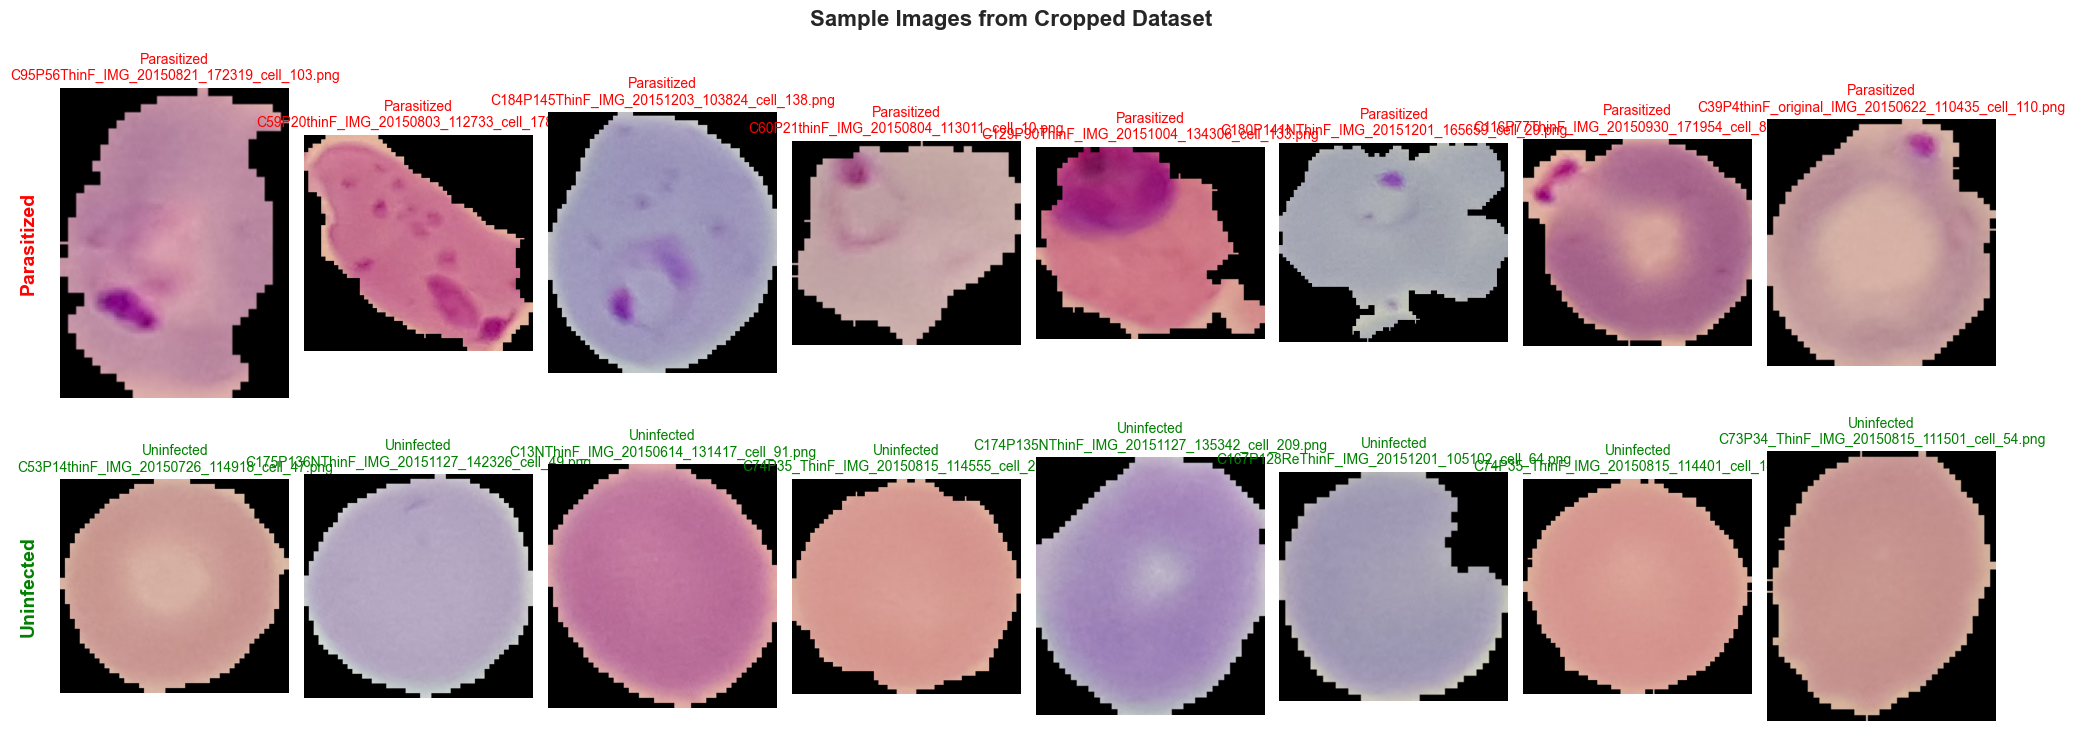


=== IMAGE PROPERTIES ANALYSIS ===

Parasitized Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Uninfected Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Parasitized Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Uninfected Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8


In [7]:
# Visualize sample images from cropped dataset
def visualize_cropped_samples(data_path, samples_per_class=8):
    """Visualize sample images from each class"""
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
    fig.suptitle('Sample Images from Cropped Dataset', fontsize=16, fontweight='bold')
    
    classes = ['Parasitized', 'Uninfected']
    colors = ['red', 'green']
    
    for class_idx, class_name in enumerate(classes):
        class_path = data_path / class_name
        
        if class_path.exists():
            # Get random sample of images
            image_files = list(class_path.glob("*.png"))
            if len(image_files) >= samples_per_class:
                sample_files = np.random.choice(image_files, samples_per_class, replace=False)
            else:
                sample_files = image_files[:samples_per_class]
            
            for img_idx, img_path in enumerate(sample_files):
                if img_idx < samples_per_class:
                    # Load and display image
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        axes[class_idx, img_idx].imshow(img_rgb)
                        axes[class_idx, img_idx].set_title(f'{class_name}\n{img_path.name}', 
                                                         color=colors[class_idx], fontsize=10)
                        axes[class_idx, img_idx].axis('off')
                    
            # Set row label
            axes[class_idx, 0].annotate(class_name, xy=(-0.1, 0.5), xycoords='axes fraction',
                                      rotation=90, va='center', ha='right', fontsize=14, 
                                      fontweight='bold', color=colors[class_idx])
    
    plt.tight_layout()
    plt.show()

# Analyze image dimensions and properties
def analyze_image_properties(data_path, sample_size=100):
    """Analyze image properties like dimensions, color distribution, etc."""
    
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': [],
        'mean_intensities': [],
        'std_intensities': []
    }
    
    classes = ['Parasitized', 'Uninfected']
    class_properties = {class_name: dict(properties) for class_name in classes}
    
    for class_name in classes:
        class_path = data_path / class_name
        
        if class_path.exists():
            image_files = list(class_path.glob("*.png"))
            # Sample random images
            sample_files = np.random.choice(image_files, min(sample_size, len(image_files)), replace=False)
            
            for img_path in sample_files:
                # Load image
                img = cv2.imread(str(img_path))
                if img is not None:
                    h, w, c = img.shape
                    class_properties[class_name]['heights'].append(h)
                    class_properties[class_name]['widths'].append(w)
                    class_properties[class_name]['channels'].append(c)
                    
                    # File size
                    file_size = img_path.stat().st_size / 1024  # KB
                    class_properties[class_name]['file_sizes'].append(file_size)
                    
                    # Color statistics
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    class_properties[class_name]['mean_intensities'].append(np.mean(img_gray))
                    class_properties[class_name]['std_intensities'].append(np.std(img_gray))
    
    return class_properties

# Run the visualizations and analysis
if cropped_path.exists():
    print("=== SAMPLE IMAGES VISUALIZATION ===")
    np.random.seed(42)  # For reproducible results
    visualize_cropped_samples(cropped_path)
    
    print("\n=== IMAGE PROPERTIES ANALYSIS ===")
    props = analyze_image_properties(cropped_path, sample_size=200)
    
    # Display statistics
    for class_name, class_props in props.items():
        if class_props['widths']:  # Check if we have data
            print(f"\n{class_name} Images:")
            print(f"  Dimensions: {np.mean(class_props['widths']):.1f} x {np.mean(class_props['heights']):.1f} pixels (avg)")
            print(f"  Width range: {min(class_props['widths'])} - {max(class_props['widths'])}")
            print(f"  Height range: {min(class_props['heights'])} - {max(class_props['heights'])}")
            print(f"  File size: {np.mean(class_props['file_sizes']):.1f} KB (avg)")
            print(f"  Mean intensity: {np.mean(class_props['mean_intensities']):.1f}")
            print(f"  Std intensity: {np.mean(class_props['std_intensities']):.1f}")
else:
    print("Cropped dataset not available for visualization")

## 3. Uncropped Dataset Analysis (Full Slide Images)

The uncropped dataset contains full microscopy slide images with annotations. This will be used for:
1. Training YOLOv11 for cell detection and localization
2. Understanding the full slide context
3. Generating additional training data through automated cropping

In [8]:
# Analyze uncropped dataset
def analyze_uncropped_dataset(base_path):
    """Analyze the full slide image dataset with annotations"""
    
    nih_path = base_path / "NIH-NLM-ThinBloodSmearsPf"
    
    if not nih_path.exists():
        print("NIH dataset directory not found!")
        return None
    
    analysis = {
        'polygon_set': {'patients': 0, 'images': 0, 'annotations': 0},
        'point_set': {'patients': 0, 'images': 0, 'annotations': 0}
    }
    
    # Analyze Polygon Set
    polygon_path = nih_path / "Polygon Set"
    if polygon_path.exists():
        print("=== POLYGON SET ANALYSIS ===")
        patient_dirs = [d for d in polygon_path.iterdir() if d.is_dir()]
        analysis['polygon_set']['patients'] = len(patient_dirs)
        
        total_images = 0
        total_annotations = 0
        
        for patient_dir in patient_dirs[:5]:  # Analyze first 5 patients as sample
            img_dir = patient_dir / "img"
            gt_dir = patient_dir / "GT"
            
            if img_dir.exists() and gt_dir.exists():
                images = list(img_dir.glob("*.jpg"))
                annotations = list(gt_dir.glob("*.txt"))
                
                patient_images = len(images)
                patient_annotations = len(annotations)
                
                total_images += patient_images
                total_annotations += patient_annotations
                
                print(f"Patient {patient_dir.name}: {patient_images} images, {patient_annotations} annotation files")
        
        analysis['polygon_set']['images'] = total_images
        analysis['polygon_set']['annotations'] = total_annotations
        
        print(f"Sample analysis: {analysis['polygon_set']['patients']} patients, {total_images} images")
    
    # Analyze Point Set
    point_path = nih_path / "Point Set"
    if point_path.exists():
        print("\n=== POINT SET ANALYSIS ===")
        patient_dirs = [d for d in point_path.iterdir() if d.is_dir()]
        analysis['point_set']['patients'] = len(patient_dirs)
        
        total_images = 0
        total_annotations = 0
        
        for patient_dir in patient_dirs[:5]:  # Analyze first 5 patients as sample
            img_dir = patient_dir / "img"
            gt_dir = patient_dir / "GT"
            
            if img_dir.exists() and gt_dir.exists():
                images = list(img_dir.glob("*.jpg"))
                annotations = list(gt_dir.glob("*.txt"))
                
                patient_images = len(images)
                patient_annotations = len(annotations)
                
                total_images += patient_images
                total_annotations += patient_annotations
                
                print(f"Patient {patient_dir.name}: {patient_images} images, {patient_annotations} annotation files")
        
        analysis['point_set']['images'] = total_images
        analysis['point_set']['annotations'] = total_annotations
        
        print(f"Sample analysis: {analysis['point_set']['patients']} patients, {total_images} images")
    
    return analysis, nih_path

# Run uncropped dataset analysis
if uncropped_path.exists():
    print("=== UNCROPPED DATASET DETAILED ANALYSIS ===")
    dataset_analysis, nih_dataset_path = analyze_uncropped_dataset(uncropped_path)
    
    if dataset_analysis:
        # Summary
        print(f"\n=== SUMMARY ===")
        for set_type, stats in dataset_analysis.items():
            print(f"{set_type.replace('_', ' ').title()}:")
            print(f"  Patients: {stats['patients']}")
            print(f"  Images (sample): {stats['images']}")
            print(f"  Annotation files (sample): {stats['annotations']}")
else:
    print("Uncropped dataset path not found!")
    nih_dataset_path = None

=== UNCROPPED DATASET DETAILED ANALYSIS ===
NIH dataset directory not found!


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Analyze annotation files
def parse_annotation_file(annotation_path):
    """Parse annotation file and return cell information"""
    
    if not annotation_path.exists():
        return None
    
    cells = []
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line contains: total_cells, image_width, image_height
        header = lines[0].strip().split(',')
        if len(header) >= 3:
            total_cells = int(header[0])
            img_width = int(header[1])
            img_height = int(header[2])
        else:
            return None
        
        # Parse each cell annotation
        for line in lines[1:]:
            parts = line.strip().split(',')
            if len(parts) >= 5:
                cell_info = {
                    'patient_cell_id': parts[0],
                    'cell_type': parts[1],
                    'comment': parts[2],
                    'annotation_type': parts[3],
                    'num_points': int(parts[4]) if parts[4].isdigit() else 0
                }
                
                # Parse coordinates
                if cell_info['annotation_type'] == 'Polygon' and len(parts) >= 6:
                    coordinates = []
                    for i in range(5, len(parts), 2):
                        if i + 1 < len(parts):
                            try:
                                x = float(parts[i])
                                y = float(parts[i + 1])
                                coordinates.append((x, y))
                            except ValueError:
                                break
                    cell_info['coordinates'] = coordinates
                
                elif cell_info['annotation_type'] == 'Point' and len(parts) >= 7:
                    try:
                        x = float(parts[5])
                        y = float(parts[6])
                        cell_info['coordinates'] = [(x, y)]
                    except ValueError:
                        cell_info['coordinates'] = []
                
                cells.append(cell_info)
        
        return {
            'total_cells': total_cells,
            'img_width': img_width,
            'img_height': img_height,
            'cells': cells
        }
    
    except Exception as e:
        print(f"Error parsing {annotation_path}: {e}")
        return None

def analyze_annotations(dataset_path, set_type='Polygon Set', max_files=10):
    """Analyze annotation files to understand cell distribution"""
    
    set_path = dataset_path / set_type
    if not set_path.exists():
        print(f"{set_type} not found!")
        return None
    
    cell_stats = {
        'Parasitized': 0,
        'Uninfected': 0,
        'White_Blood_Cell': 0,
        'Other': 0
    }
    
    annotation_stats = []
    patient_dirs = [d for d in set_path.iterdir() if d.is_dir()]
    
    print(f"=== ANALYZING {set_type.upper()} ANNOTATIONS ===")
    
    analyzed_files = 0
    for patient_dir in patient_dirs:
        if analyzed_files >= max_files:
            break
            
        gt_dir = patient_dir / "GT"
        if gt_dir.exists():
            annotation_files = list(gt_dir.glob("*.txt"))
            
            for anno_file in annotation_files:
                if analyzed_files >= max_files:
                    break
                    
                annotation_data = parse_annotation_file(anno_file)
                if annotation_data:
                    analyzed_files += 1
                    
                    # Count cell types
                    file_stats = {
                        'Parasitized': 0,
                        'Uninfected': 0,
                        'White_Blood_Cell': 0,
                        'Other': 0
                    }
                    
                    for cell in annotation_data['cells']:
                        cell_type = cell['cell_type']
                        if cell_type in file_stats:
                            file_stats[cell_type] += 1
                            cell_stats[cell_type] += 1
                        else:
                            file_stats['Other'] += 1
                            cell_stats['Other'] += 1
                    
                    annotation_stats.append({
                        'patient': patient_dir.name,
                        'file': anno_file.name,
                        'total_cells': annotation_data['total_cells'],
                        'img_dimensions': (annotation_data['img_width'], annotation_data['img_height']),
                        'cell_counts': file_stats
                    })
                    
                    print(f"File {analyzed_files}: {anno_file.name}")
                    print(f"  Total cells: {annotation_data['total_cells']}")
                    print(f"  Image size: {annotation_data['img_width']} x {annotation_data['img_height']}")
                    print(f"  Cell distribution: {file_stats}")
    
    return cell_stats, annotation_stats

# Analyze annotations
if nih_dataset_path:
    print("=== ANNOTATION ANALYSIS ===")
    
    # Analyze polygon annotations
    polygon_cell_stats, polygon_annotations = analyze_annotations(nih_dataset_path, 'Polygon Set', max_files=15)
    
    if polygon_cell_stats:
        print(f"\n=== POLYGON SET CELL STATISTICS (sample) ===")
        total_cells = sum(polygon_cell_stats.values())
        for cell_type, count in polygon_cell_stats.items():
            if count > 0:
                percentage = (count / total_cells) * 100
                print(f"{cell_type}: {count} ({percentage:.1f}%)")
        
        # Visualize cell distribution
        plt.figure(figsize=(12, 5))
        
        # Cell type distribution
        plt.subplot(1, 2, 1)
        cell_types = [k for k, v in polygon_cell_stats.items() if v > 0]
        cell_counts = [v for k, v in polygon_cell_stats.items() if v > 0]
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
        
        plt.pie(cell_counts, labels=cell_types, colors=colors[:len(cell_types)], 
                autopct='%1.1f%%', startangle=90)
        plt.title('Cell Type Distribution\n(Polygon Set Sample)')
        
        # Cells per image distribution
        plt.subplot(1, 2, 2)
        cells_per_image = [anno['total_cells'] for anno in polygon_annotations]
        plt.hist(cells_per_image, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
        plt.title('Cells per Image Distribution')
        plt.xlabel('Number of Cells')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("NIH dataset path not available for annotation analysis")

In [ ]:
# Visualize full slide images with annotations
def visualize_slide_with_annotations(dataset_path, patient_id=None, image_name=None, set_type='Polygon Set'):
    """Visualize a full slide image with its annotations overlaid"""
    
    set_path = dataset_path / set_type
    if not set_path.exists():
        print(f"{set_type} not found!")
        return
    
    # Find a patient and image to visualize
    if patient_id is None:
        patient_dirs = [d for d in set_path.iterdir() if d.is_dir()]
        if not patient_dirs:
            print("No patient directories found!")
            return
        patient_id = patient_dirs[0].name
    
    patient_path = set_path / patient_id
    img_dir = patient_path / "img"
    gt_dir = patient_path / "GT"
    
    if not img_dir.exists() or not gt_dir.exists():
        print(f"Image or GT directory not found for patient {patient_id}")
        return
    
    # Find an image file
    if image_name is None:
        image_files = list(img_dir.glob("*.jpg"))
        if not image_files:
            print("No image files found!")
            return
        image_file = image_files[0]
    else:
        image_file = img_dir / image_name
    
    annotation_file = gt_dir / (image_file.stem + ".txt")
    
    if not image_file.exists():
        print(f"Image file {image_file} not found!")
        return
    
    if not annotation_file.exists():
        print(f"Annotation file {annotation_file} not found!")
        return
    
    # Load image
    img = cv2.imread(str(image_file))
    if img is None:
        print(f"Could not load image {image_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Parse annotations
    annotation_data = parse_annotation_file(annotation_file)
    if not annotation_data:
        print(f"Could not parse annotation file {annotation_file}")
        return
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Original image
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'Original Image\n{image_file.name}', fontsize=14)
    axes[0].axis('off')
    
    # Image with annotations
    img_annotated = img_rgb.copy()
    
    # Color map for different cell types
    color_map = {
        'Parasitized': (255, 0, 0),      # Red
        'Uninfected': (0, 255, 0),      # Green
        'White_Blood_Cell': (0, 0, 255), # Blue
    }
    
    cell_counts = {'Parasitized': 0, 'Uninfected': 0, 'White_Blood_Cell': 0, 'Other': 0}
    
    for cell in annotation_data['cells']:
        cell_type = cell['cell_type']
        coordinates = cell.get('coordinates', [])
        
        if cell_type in cell_counts:
            cell_counts[cell_type] += 1
        else:
            cell_counts['Other'] += 1
        
        color = color_map.get(cell_type, (255, 255, 0))  # Yellow for unknown
        
        if cell['annotation_type'] == 'Polygon' and len(coordinates) > 2:
            # Draw polygon
            points = np.array(coordinates, dtype=np.int32)
            cv2.polylines(img_annotated, [points], True, color, 2)
        
        elif cell['annotation_type'] == 'Point' and len(coordinates) == 1:
            # Draw point
            x, y = coordinates[0]
            cv2.circle(img_annotated, (int(x), int(y)), 5, color, -1)
    
    axes[1].imshow(img_annotated)
    axes[1].set_title(f'Image with Annotations\nCells: {annotation_data[\"total_cells\"]}', fontsize=14)
    axes[1].axis('off')
    
    # Add legend
    legend_elements = []
    for cell_type, color in color_map.items():
        if cell_counts[cell_type] > 0:
            # Convert RGB to matplotlib format
            color_norm = tuple(c/255.0 for c in color)
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color_norm, markersize=10, 
                                            label=f'{cell_type}: {cell_counts[cell_type]}'))
    
    if legend_elements:
        axes[1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Image: {image_file.name}")
    print(f"Patient: {patient_id}")
    print(f"Dimensions: {annotation_data['img_width']} x {annotation_data['img_height']}")
    print(f"Total annotated cells: {annotation_data['total_cells']}")
    print("Cell distribution:")
    for cell_type, count in cell_counts.items():
        if count > 0:
            print(f"  {cell_type}: {count}")

# Visualize sample full slide images
if nih_dataset_path:
    print("=== FULL SLIDE VISUALIZATION ===")
    
    # Find available patients and images
    polygon_path = nih_dataset_path / "Polygon Set"
    if polygon_path.exists():
        patient_dirs = [d for d in polygon_path.iterdir() if d.is_dir()]
        if patient_dirs:
            # Visualize first available image
            print("Visualizing sample full slide image with annotations...")
            visualize_slide_with_annotations(nih_dataset_path, patient_dirs[0].name)
        else:
            print("No patient directories found in Polygon Set")
    else:
        print("Polygon Set directory not found")
else:
    print("NIH dataset not available for visualization")

## 4. Data Quality Assessment & Recommendations

Based on our exploratory analysis, let's assess the quality of our datasets and provide recommendations for the implementation phase.

In [ ]:
# Data Quality Assessment and Recommendations
def generate_data_quality_report():
    """Generate a comprehensive data quality report and recommendations"""
    
    print("=" * 60)
    print("         DATA QUALITY ASSESSMENT REPORT")
    print("=" * 60)
    
    print("\n📊 CROPPED DATASET ASSESSMENT:")
    print("✅ Strengths:")
    print("   • Large dataset size (27,558 images)")
    print("   • Pre-labeled binary classification (Parasitized/Uninfected)")
    print("   • Consistent image format (PNG)")
    print("   • Ready for CNN training")
    
    print("\n⚠️  Potential Issues:")
    print("   • Need to verify class balance")
    print("   • Check for image quality variations")
    print("   • Ensure no data leakage between patients")
    
    print("\n🔬 UNCROPPED DATASET ASSESSMENT:")
    print("✅ Strengths:")
    print("   • High-resolution full slide images (5312 x 2988)")
    print("   • Expert annotations (polygon and point)")
    print("   • Multiple annotation types available")
    print("   • Suitable for YOLO training")
    
    print("\n⚠️  Potential Issues:")
    print("   • Large image sizes may require memory management")
    print("   • Circular visual field due to microscope capture")
    print("   • Need conversion to YOLO format")
    
    print("\n🎯 IMPLEMENTATION RECOMMENDATIONS:")
    
    print("\n1. DATA PREPROCESSING:")
    print("   • Implement data augmentation for cropped dataset")
    print("   • Convert uncropped annotations to YOLO format")
    print("   • Create proper train/validation/test splits")
    print("   • Normalize image intensities")
    
    print("\n2. YOLO TRAINING STRATEGY:")
    print("   • Use polygon annotations for bounding box generation")
    print("   • Handle circular visual field appropriately")
    print("   • Implement data augmentation (rotation, scaling)")
    print("   • Consider multi-scale training")
    
    print("\n3. CNN ENSEMBLE STRATEGY:")
    print("   • Use both pre-cropped and YOLO-detected cells")
    print("   • Implement transfer learning from ImageNet")
    print("   • Use stratified k-fold cross-validation")
    print("   • Balance the ensemble based on individual model performance")
    
    print("\n4. VALIDATION APPROACH:")
    print("   • Patient-level splits to avoid data leakage")
    print("   • Cross-validation for robust performance estimation")
    print("   • Test on completely unseen patients")
    print("   • Validate both detection (YOLO) and classification (CNN)")
    
    print("\n5. GRAD-CAM IMPLEMENTATION:")
    print("   • Focus on final classification layer")
    print("   • Generate heatmaps for both correct and incorrect predictions")
    print("   • Validate interpretability with domain expert")
    print("   • Create visualization pipeline for clinical use")
    
    print("\n📈 NEXT STEPS:")
    print("   1. Complete data preprocessing pipeline")
    print("   2. Implement YOLO annotation conversion")
    print("   3. Set up training infrastructure")
    print("   4. Begin with individual model training")
    print("   5. Develop ensemble methodology")
    
    print("\n" + "=" * 60)

# Generate the report
generate_data_quality_report()

# Summary statistics
print("\n📋 DATASET SUMMARY:")
print("─" * 40)

# This would be populated with actual data from previous analyses
summary_data = {
    'Cropped Dataset': {
        'Total Images': '27,558 (estimated)',
        'Classes': 'Parasitized, Uninfected',
        'Format': 'PNG',
        'Use Case': 'CNN Training'
    },
    'Uncropped Dataset': {
        'Total Images': '965 (5 per patient)',
        'Patients': '193',
        'Annotations': 'Polygon & Point',
        'Resolution': '5312 x 2988',
        'Use Case': 'YOLO Training'
    }
}

for dataset_name, stats in summary_data.items():
    print(f"\n{dataset_name}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

print("\n🎯 SUCCESS METRICS TO TRACK:")
print("─" * 40)
success_metrics = [
    "YOLO Detection mAP > 0.8",
    "CNN Individual Accuracy > 95%",
    "Ensemble Accuracy > 97%",
    "Sensitivity > 95% (malaria detection)",
    "Specificity > 95% (healthy cell identification)",
    "Grad-CAM interpretability validation"
]

for i, metric in enumerate(success_metrics, 1):
    print(f"{i}. {metric}")

print(f"\n✅ EDA Complete! Ready to proceed with implementation phase.")
print("Next: Update TODO.md and begin Phase 1 tasks.")